In [1]:
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

### Strategy

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
print(f"Numbers of GPU: { strategy.num_replicas_in_sync }")

Numbers of GPU: 2


### Reading the Data

In [4]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [5]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180)
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180)
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180)
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

tr_d = tr_d.prefetch(buffer_size=AUTOTUNE)
va_d = va_d.prefetch(buffer_size=AUTOTUNE)
te_d = te_d.prefetch(buffer_size=AUTOTUNE)

### Augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

### The Model

In [8]:
with strategy.scope():
    inputs = keras.Input(shape=(180,180,3))

    x = data_augmentation(inputs)

    # Instantiating VGG16
    conv_base = keras.applications.vgg16.VGG16(
        include_top=False,
        weights='imagenet'
    )

    conv_base.trainable = False

    # Feature estraction
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)

    # our Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

### Training

In [9]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath='CatsVsDogs-Fine-tuning-FeatureStraction-VGG16.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    
    # To monitoring the training on TensorBoard
    keras.callbacks.TensorBoard(
        log_dir='/home/antirrabia/Documents/DeepLearnin/Notebooks/TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d,
    epochs=52,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/52
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

### Printing the training before Fine-tuning

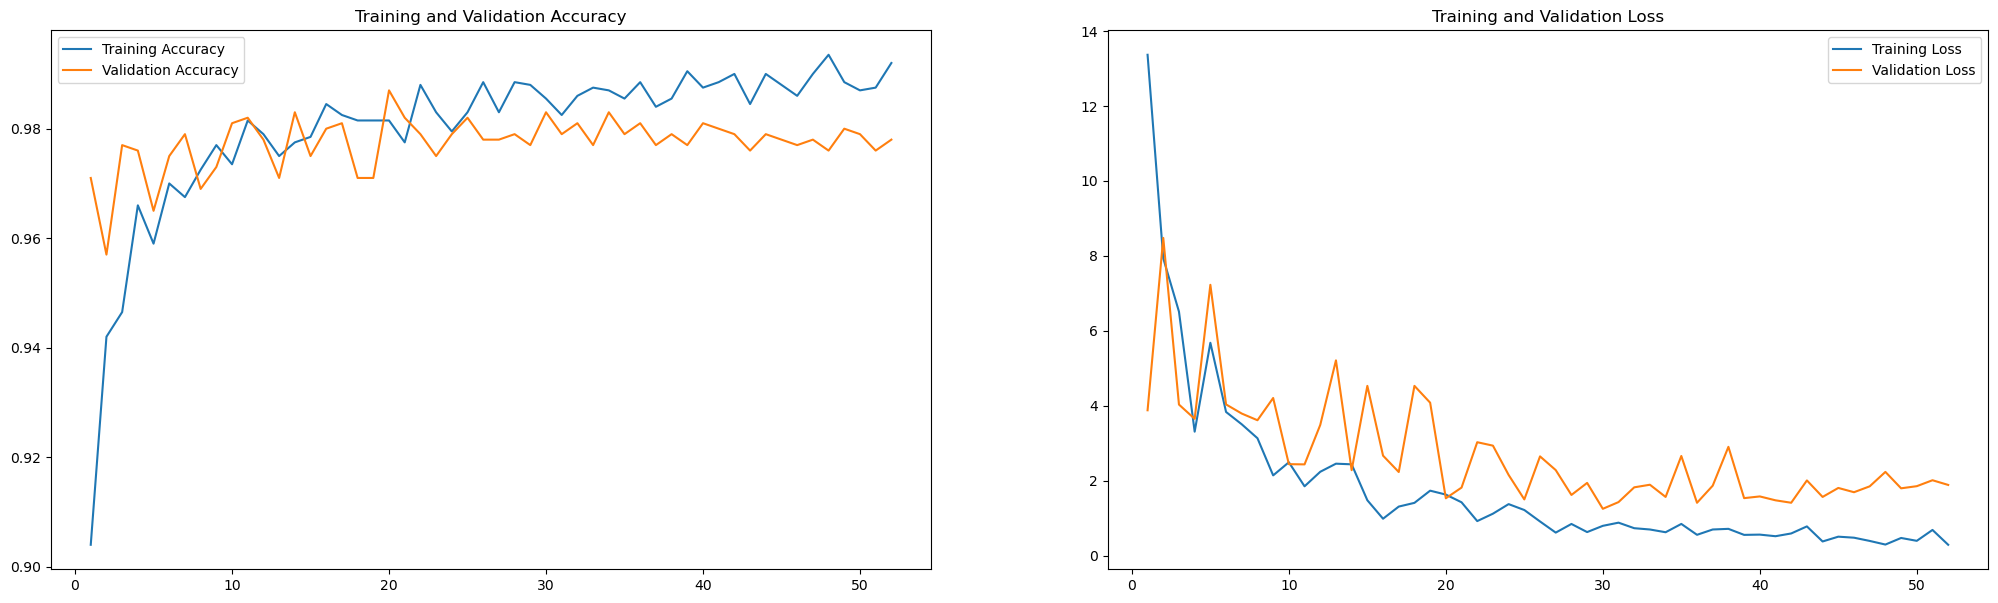

In [10]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len( accuracy) + 1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_acc, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss');
ax[1].legend()

In [11]:
te_model = keras.models.load_model('CatsVsDogs-Fine-tuning-FeatureStraction-VGG16.keras')

te_loss, te_acc = te_model.evaluate(te_d)

print(f"\n\nTest accuracy(Before Fine-tuning): {te_acc:.3f}")

63/63 [==============================] - 10s 107ms/step - loss: 2.2634 - accuracy: 0.9760


Test accuracy(Before Fine-tuning): 0.976


### Fine-tuning State

In [16]:
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
    layer.trainable = False

### New Compile

In [17]:
with strategy.scope():
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

### New Training including the tops 3 conv2d from VGG16

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='CatsVsDogs-Fine-tuning-FeatureStraction-VGG16.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    
    # To monitoring on TensorBoard
    keras.callbacks.TensorBoard(
        log_dir='/home/antirrabia/Documents/DeepLearnin/Notebooks/TensorBoard_Logs/'
    )
]

ft_history = model.fit(
    tr_d,
    epochs=25,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
63/63 [==============================] - 13s 153ms/step - loss: 0.2713 - accuracy: 0.9930 - val_loss: 1.5299 - val_accuracy: 0.9800
Epoch 2/25
63/63 [==============================] - 9s 146ms/step - loss: 0.3933 - accuracy: 0.9890 - val_loss: 1.3593 - val_accuracy: 0.9820
Epoch 3/25
63/63 [==============================] - 9s 139ms/step - loss: 0.0907 - accuracy: 0.9945 - val_loss: 1.3703 - val_accuracy: 0.9820
Epoch 4/25
63/63 [==============================] - 9s 141ms/step - loss: 0.3893 - accuracy: 0.9910 - val_loss: 1.7061 - val_accuracy: 0.9780
Epoch 5/25
63/63 [==============================] - 9s 143ms/step - loss: 0.2822 - accuracy: 0.9925 - val_loss: 1.4633 - val_accuracy: 0.9790
Epoch 6/25
63/63 [==============================] - 9s 146ms/step - loss: 0.3334 - accuracy: 0.9905 - val_loss: 2.258

### Printing the new training with fine-tuning

In [20]:
ft_accuracy = ft_history.history['accuracy']
ft_val_acc = ft_history.history['val_accuracy']

ft_loss = ft_history.history['loss']
ft_val_loss = ft_history.history['val_loss']

ft_epochs = range(1, len(ft_accuracy)+1)

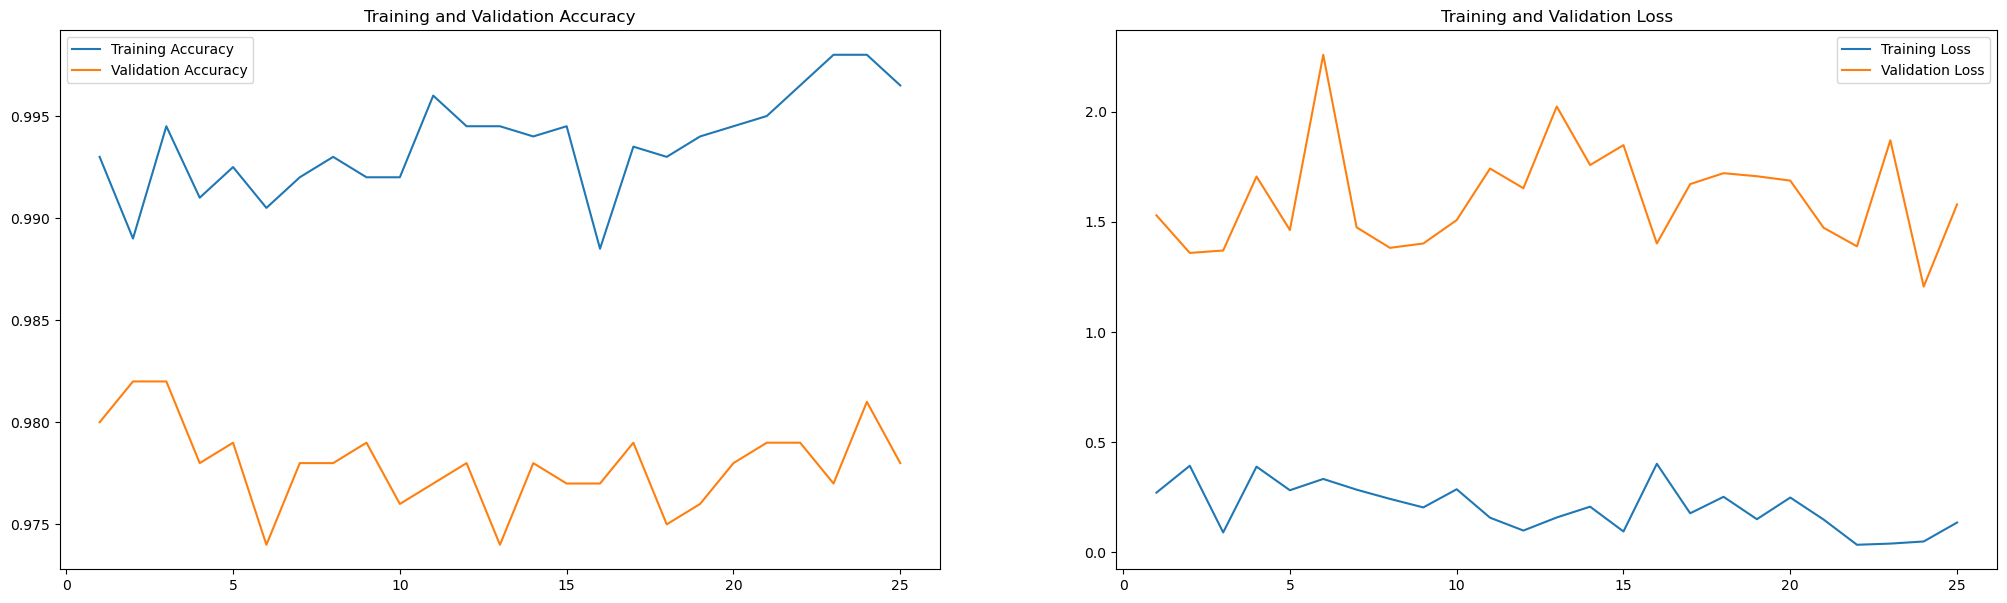

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,7))

ax[0].plot(ft_epochs, ft_accuracy, label='Training Accuracy')
ax[0].plot(ft_epochs, ft_val_acc, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(ft_epochs, ft_loss, label='Training Loss')
ax[1].plot(ft_epochs, ft_val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

### Evaluating the Fine-tuning

In [22]:
ft_te_model = keras.models.load_model('CatsVsDogs-Fine-tuning-FeatureStraction-VGG16.keras')

ft_te_loss, ft_te_acc = ft_te_model.evaluate(te_d)

print(f"Fine-tunin test accuracy: {ft_te_acc:.3f}")

63/63 [==============================] - 7s 107ms/step - loss: 1.9060 - accuracy: 0.9765
Fine-tunin test accuracy: 0.976
